<a href="https://colab.research.google.com/github/kramorov/kramorov/blob/main/_18_Ultra_Light_%D0%92%D0%B0%D1%80%D0%B8%D0%B0%D1%86%D0%B8%D0%BE%D0%BD%D0%BD%D1%8B%D0%B5_%D0%B0%D0%B2%D1%82%D0%BE%D0%BA%D0%BE%D0%B4%D0%B8%D1%80%D0%BE%D0%B2%D1%89%D0%B8%D0%BA%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задание Ultra Lite

Перепишите вариационный автокодировщик на базе Mnist с нуля в новом ноутбуке. Можно подсматривать в ноутбук занятия, но лучше писать код своими руками, а не копировать

In [1]:
import sys # модуль содержит параметры и функции, которые относятся к Python и его среде
import numpy as np # загружаем библиотеку для работы с массивами данных
import matplotlib.pyplot as plt # из библиотеки для визуализации данных возьмём интерфейс для построения графиков простых функций
import seaborn as sns # более высокоуровневое API на базе библиотеки matplotlib
from scipy.stats import norm # модуль с нормальными непрерывными случайными величинами
#from keras.datasets import fashion_mnist # загружаем готовую базу mnist(fashion- с одеждой, обувью и т.п)

from tensorflow.keras.datasets import mnist # загружаем готовую стандартную базу рукописных цифр mnist
from tensorflow.keras.optimizers import Adam, RMSprop # загружаем выбранные оптимизаторы
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Layer  # загружаем необходимые слои(входной, полносвязный)
from tensorflow.keras.layers import BatchNormalization, Dropout, Flatten, Reshape, Lambda, Conv2DTranspose, Conv2D, MaxPool2D
from tensorflow.keras.models import Model # загружаем абстрактный класс базовой модели сети от кераса
from tensorflow.keras.losses import binary_crossentropy # импортируем функцию потерь

from tensorflow.keras import backend as K 
from tensorflow.keras import metrics as K_metrics
from tensorflow import GradientTape
from tensorflow import math as tf_math

from tensorflow.keras.callbacks import LambdaCallback, ReduceLROnPlateau, TensorBoard # импортируем коллбэки


In [2]:
from google.colab import drive #модуль для работы с google диском
drive.mount('/content/drive/') # монтируем google диск

Mounted at /content/drive/


In [7]:
def plot_digits(number_of_digits, digit_size, decoder):
  figure = np.zeros((digit_size * number_of_digits, digit_size * number_of_digits))

  grid_x = np.linspace(-1, 1,number_of_digits)
  grid_y = np.linspace(-1, 1, number_of_digits)[::-1]

  for i, yi in enumerate(grid_y):
      for j, xi in enumerate(grid_x):
          z_sample = np.array([[xi, yi]])
          x_decoded = decoder.predict(z_sample)
          digit = x_decoded[0].reshape(digit_size, digit_size)
          figure[
              i * digit_size : (i + 1) * digit_size,
              j * digit_size : (j + 1) * digit_size,
          ] = 1-digit

  plt.figure(figsize=(15, 15))
  start_range = digit_size // 2
  end_range = number_of_digits * digit_size + start_range
  pixel_range = np.arange(start_range, end_range, digit_size)
  sample_range_x = np.round(grid_x, 1)
  sample_range_y = np.round(grid_y, 1)
  plt.xticks(pixel_range, sample_range_x)
  plt.yticks(pixel_range, sample_range_y)
  plt.xlabel("z[0]")
  plt.ylabel("z[1]")
  plt.axis("off")
  plt.imshow(figure, cmap="Greys_r")
  plt.show()

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data() # загружаем данные из базы mnist с разбивкой на train/test
#(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data() # загружаем данные из базы fashion_mnist с разбивкой на train/test

x_train = x_train.astype('float32') / 255. # представляем x_train в виде значений от 0 до 1
x_test  = x_test .astype('float32') / 255. # представляем x_test в виде значений от 0 до 1
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1)) # меняем форму, приводим к нужным нам размерам
x_test  = np.reshape(x_test,  (len(x_test),  28, 28, 1)) # меняем форму, приводим к нужным нам размерам

11493376/11490434 [==============================] - 0s 0us/step


# Вариационный автокодировщик
Модель собрана на основе ООП TensorFlow.<br>
При инициализации, на вход модели подаются:<br>
* **input_shape** - размерность входного тензора (для MNIST цифры - (28, 28,1)
* **latent_layer_dim** - размерность латентного слоя
* **reconstruction_loss_weight** - доля reconstruction_loss в общем loss **(должна быть в диапазоне от 0 до 1)**. При расчете функции потерь, мы используем 2 веса - один для reconstruction_loss, второй для kl_loss. В сумме они равны 1. Вес для kl_loss рассчитывается при инициализации класса модели.

Для вычисления loss и обновления градиента используется собственная функция.
Поскольку оценка ошибки осуществляется на основании собственной функции, **при вызове метода fit передавать x_test не нужно**.

При использовании классов Model, Layer в качестве родителей для самописных классов, TensorFlow требует, чтобы в коде самописного класса была определен метод класса **call** для выполнения кода класса.

После тренировки модели делаем визуализацию работы латентного слоя.

In [5]:
class MyVae(Model):
  class MyEpsilon(Layer):
    def call (self, z_mean, z_log_var, latent_dim):# При использовании класса Layer в качестве родителей для самописных классов, 
                        # TensorFlow требует, чтобы в коде самописного класса была определен метод класса **call** 
                        # для выполнения кода класса
      epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),mean=0., stddev=1.)
      return z_mean + K.exp(z_log_var) * epsilon
  def __init__(self, input_shape, latent_layer_dim, reconstruction_loss_weight, **kwargs):
    super().__init__(**kwargs)
    self.shape_before_flatten = 0
    self.shape_after_flatten = 0 
    self.latent_dim=latent_layer_dim
    self.encoder = self.get_encoder(input_shape, latent_layer_dim)
    self.decoder = self.get_decoder(latent_layer_dim)
    
    self.add_epsilon = self.MyEpsilon()
    self.total_loss_tracker = K_metrics.Mean(name="total_loss")  # Здесь обьявляем тип внутренней переменной. Метрики имеют состояния, нужен инстанс класса
    self.reconstruction_loss_tracker = K_metrics.Mean(name="reconstruction_loss") # Здесь обьявляем тип внутренней переменной
    self.kl_loss_tracker = K_metrics.Mean(name="kl_loss") # Здесь обьявляем тип внутренней переменной
    self.reconstruction_loss_weight=reconstruction_loss_weight  
    self.kl_loss_weight= 1- self.reconstruction_loss_weight
  def call(self, data): # При использовании класса Model в качестве родителей для самописных классов, 
                      # TensorFlow требует, чтобы в коде самописного класса была определен метод класса **call** 
                      # для выполнения кода класса
    z = self.encoder(data)
    y_pred = self.decoder(z) 
    return y_pred      
  def get_encoder(self, input_shape, latent_layer_dim):
    input_encode=Input(shape=input_shape) # Если на входе 28, 28,1 то выход далее 28, 28,1
    x_encode = Conv2D(32, 3, padding='same', activation='relu')(input_encode) # output shape = 28, 28, 32
    #x_encode = MaxPool2D(2, name='MP_1')(x_encode)
    x_encode = Conv2D(64, 3, strides=(2,2), padding='same', activation='relu')(x_encode) # Генерализуем изображение output shape = 14, 14, 64 (strides=(2,2))
    #x_not_flatten = MaxPool2D(2, name='MP_2')(x_encode)
    x_encode = Conv2D(64, 3, padding='same', activation='relu')(x_encode)
    x_not_flatten = Conv2D(64, 3, padding='same', activation='relu')(x_encode)
    #x_not_flatten = MaxPool2D(2)(x_not_flatten)
    self.shape_before_flatten = K.int_shape(x_not_flatten) # х.з что сюда приедет при других входных размерностях
    x_encode_flatten=Flatten()(x_not_flatten) # output shape = 14*14*64 = 12544
    self.shape_after_flatten = K.int_shape(x_encode_flatten)
    #x_encode_flatten=Dense(128, activation='relu')(x_encode_flatten) # output shape = 32
    x_encode_flatten=Dense(32, activation='relu')(x_encode_flatten) # output shape = 32
    z_mean = Dense(latent_layer_dim, name='z_mean')(x_encode_flatten) # shape = 2 = latent_layer_dim
    z_log_var = Dense(latent_layer_dim, name='z_log_var')(x_encode_flatten)  #  shape = 2 = latent_layer_dim
    encoder=Model(input_encode, [z_mean, z_log_var], name = 'encoder')

    return encoder

  def get_decoder(self, latent_layer_dim):
    shape_without_batch=self.shape_before_flatten[1:] # Убираем первое None (batch) в 
    first_dense_dim=np.prod(shape_without_batch) # Размерность после Flatten в энкодере
    
    latent_inputs =Input(shape=(latent_layer_dim,))
    
    x_decode=Dense(32, activation='relu')(latent_inputs) # output shape = 32
    x_decode=Dense(128, activation='relu')(x_decode) # output shape = 32
    #x_decode=Dense(self.shape_after_flatten[1:], activation='relu')(x_decode)
    #x_decode=Dense(self.shape_after_flatten[1], activation='relu')(x_decode) # 3136
    x_decode=Dense(first_dense_dim, activation='relu')(x_decode)
    x_decode_not_flatten=Reshape(shape_without_batch)(x_decode) # Возвращаем размерность как до Flatten, для дальнейшей обработки (7,7,64)
    #x_decode_not_flatten = Conv2DTranspose(64, 3, strides=(2,2), padding='same', activation='relu')(x_decode_not_flatten) # Делаем обратое преобразование к тому, что мы вытворяли в энкодере
    x_decode_not_flatten = Conv2DTranspose(32, 3, strides=(2,2),padding='same', activation='relu')(x_decode_not_flatten) # Делаем обратое преобразование к тому, что мы вытворяли в энкодере
    #x_decode_not_flatten = Conv2DTranspose(32, (3,3), padding='same', activation='relu')(x_decode_not_flatten) # Делаем обратое преобразование к тому, что мы вытворяли в энкодере
    output_decode =Conv2D(1, 3, padding='same', activation='sigmoid')(x_decode_not_flatten)
    decoder=Model(latent_inputs, output_decode, name='decoder')
    return decoder  
  @property  # Фактически getter
  def metrics(self):
      return [self.total_loss_tracker,
              self.reconstruction_loss_tracker,
              self.kl_loss_tracker]

  def train_step(self, data):
      with GradientTape() as tape: 
          z_mean, z_log_var = self.encoder(data)
          new_z_with_epsilon = self.add_epsilon(z_mean, z_log_var,self.latent_dim)
          reconstruction = self.decoder(new_z_with_epsilon) # Прогоняем через декодер значение с добавленной эпсилон (смещение по стандартному нормальному распределению)
          # Оцениваем потери восстановленного декодером значения (с эпсилон)
          reconstruction_loss = tf_math.reduce_mean( # Аналог np.mean. Рассчитывает среднее по элементам тензора в аргументе, возвращает свернутый по указанным осям тензор
                                                #   Поскольку оси мы не указываем, возвращает одномерный тензор
               tf_math.reduce_sum( binary_crossentropy(data, reconstruction),axis=(1, 2) )  # Аналог np.sum. 
                              # Рассчитывает сумму по элементам тензора в аргументе, возвращает свернутый по указанным осям тензор
                              # Мы указали оси 1,2 возвращает одномерный тензор по каждому элементу батча
              )
          kl_loss = -0.5 * (1 + z_log_var -  tf_math.square(z_mean) -  tf_math.exp(z_log_var))
          total_loss = self.reconstruction_loss_weight*reconstruction_loss +  self.kl_loss_weight*tf_math.reduce_mean(kl_loss)  # Подсчитали свой собственный loss
      grads = tape.gradient(total_loss, self.trainable_weights) # Считаем новые градиенты для весов по собственному loss
      self.optimizer.apply_gradients(zip(grads, self.trainable_weights)) # И прописываем их в модель
      self.total_loss_tracker.update_state(total_loss) # Обновляем свои переменные
      self.reconstruction_loss_tracker.update_state(reconstruction_loss)
      self.kl_loss_tracker.update_state(kl_loss)
      return {
          "total_loss": self.total_loss_tracker.result(),
          "reconstruction_loss": self.reconstruction_loss_tracker.result(),
          "kl_loss": self.kl_loss_tracker.result(),
      }
  

# Эксперимент 1:
Установим веса **reconstruction_loss** и **kl_loss** одинаковые = 0.5

Epoch 1/20
469/469 [==============================] - 13s 28ms/step - total_loss: 107.1832 - reconstruction_loss: 213.4057 - kl_loss: 0.9599
Epoch 2/20
469/469 [==============================] - 14s 29ms/step - total_loss: 97.4241 - reconstruction_loss: 193.2552 - kl_loss: 1.5923
Epoch 3/20
469/469 [==============================] - 13s 29ms/step - total_loss: 96.3776 - reconstruction_loss: 191.1704 - kl_loss: 1.5845
Epoch 4/20
469/469 [==============================] - 13s 29ms/step - total_loss: 95.7812 - reconstruction_loss: 189.9461 - kl_loss: 1.6164
Epoch 5/20
469/469 [==============================] - 14s 29ms/step - total_loss: 95.1743 - reconstruction_loss: 188.6566 - kl_loss: 1.6920
Epoch 6/20
469/469 [==============================] - 13s 28ms/step - total_loss: 94.6800 - reconstruction_loss: 187.6426 - kl_loss: 1.7176
Epoch 7/20
469/469 [==============================] - 13s 28ms/step - total_loss: 94.3263 - reconstruction_loss: 186.8858 - kl_loss: 1.7668
Epoch 8/20
469/469 

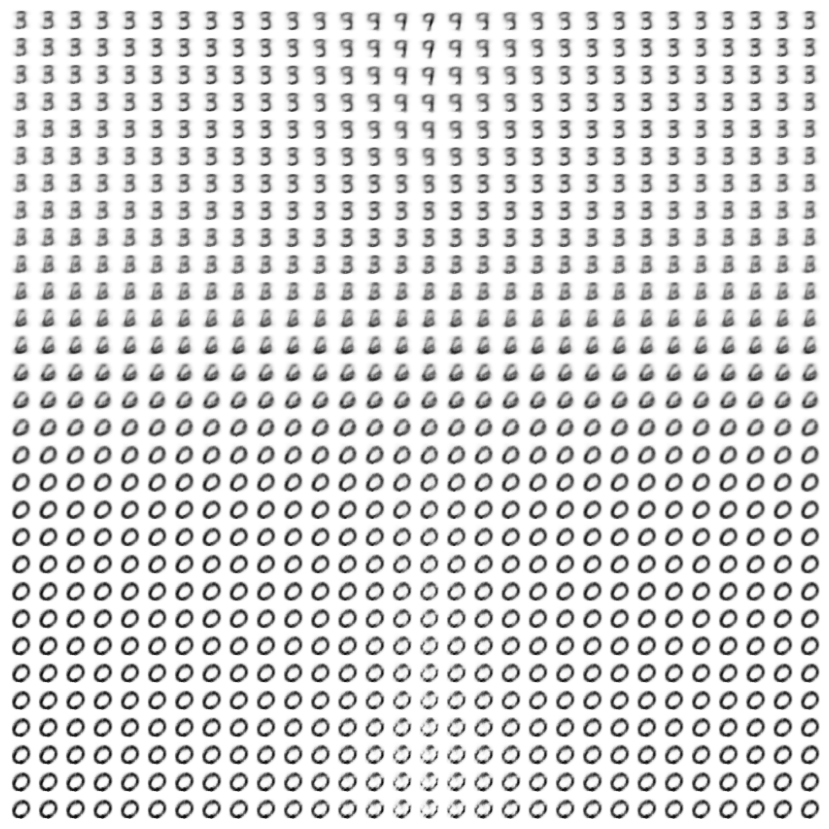

In [8]:
vae=MyVae((28,28,1), 2, 0.5)
vae.compile(optimizer=Adam(), run_eagerly=True) # run_eagerly - для запуска своего пересчета градиента
vae.fit(x_train, epochs=20, batch_size=128)
plot_digits(number_of_digits=30, digit_size=28, decoder=vae.decoder)

# Обсуждение эксперимента 1:
Мы видим, что пространство латентного слоя недостаточно плотное. Об этом говорит отсутствие некоторых сиволов цифр в выборке

# Эксперимент 2:
Изменим вес **reconstruction_loss** - вместо 0.5 сделаем **0.3**. Таким образом, его важность для результата обучения уменьшится, а **важность kl_loss - увеличится**.

Epoch 1/20
469/469 [==============================] - 14s 29ms/step - total_loss: 57.6743 - reconstruction_loss: 189.6335 - kl_loss: 1.1202
Epoch 2/20
469/469 [==============================] - 13s 29ms/step - total_loss: 48.1028 - reconstruction_loss: 156.9719 - kl_loss: 1.4447
Epoch 3/20
469/469 [==============================] - 13s 29ms/step - total_loss: 46.0005 - reconstruction_loss: 149.7424 - kl_loss: 1.5396
Epoch 4/20
469/469 [==============================] - 13s 28ms/step - total_loss: 44.9675 - reconstruction_loss: 146.1742 - kl_loss: 1.5933
Epoch 5/20
469/469 [==============================] - 13s 29ms/step - total_loss: 44.3497 - reconstruction_loss: 144.0275 - kl_loss: 1.6307
Epoch 6/20
469/469 [==============================] - 14s 29ms/step - total_loss: 43.8504 - reconstruction_loss: 142.3058 - kl_loss: 1.6553
Epoch 7/20
469/469 [==============================] - 13s 28ms/step - total_loss: 43.4765 - reconstruction_loss: 141.0075 - kl_loss: 1.6774
Epoch 8/20
469/469 [

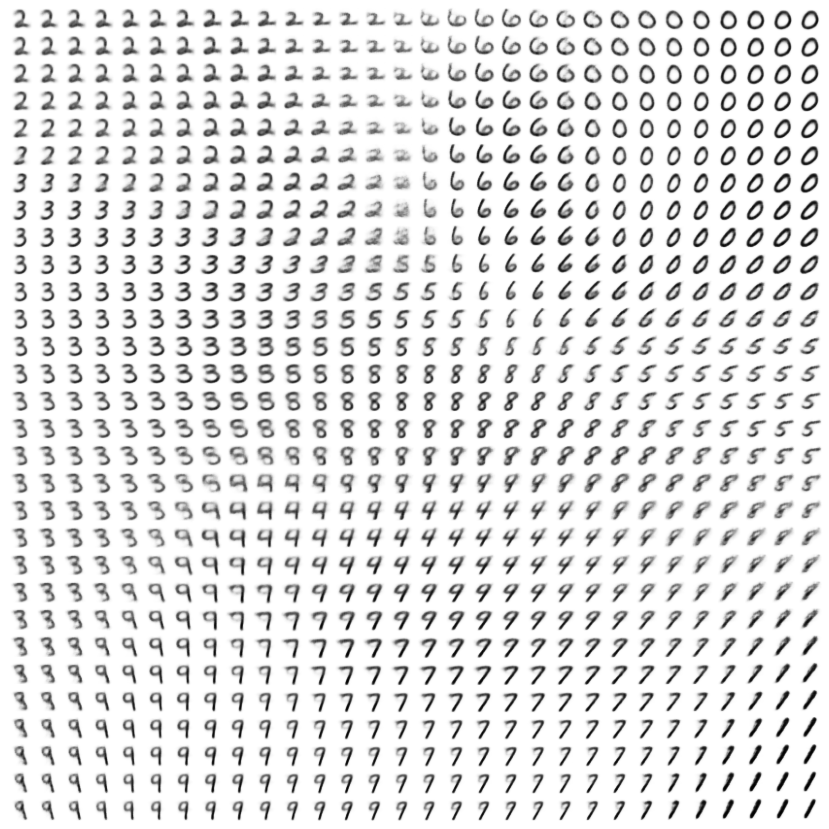

In [9]:
vae=MyVae((28,28,1), 2, 0.3)
vae.compile(optimizer=Adam(), run_eagerly=True) # run_eagerly - для запуска своего пересчета градиента
vae.fit(x_train, epochs=20, batch_size=128)
plot_digits(number_of_digits=30, digit_size=28, decoder=vae.decoder)

# Обсуждение эксперимента 2:
Четкость написания символов увеличилась

# Эксперимент 3:
Изменим вес **reconstruction_loss** - сделаем **0.7**.

Epoch 1/20
469/469 [==============================] - 14s 29ms/step - total_loss: 143.7187 - reconstruction_loss: 204.1968 - kl_loss: 2.6024
Epoch 2/20
469/469 [==============================] - 13s 28ms/step - total_loss: 128.3551 - reconstruction_loss: 181.2884 - kl_loss: 4.8430
Epoch 3/20
469/469 [==============================] - 13s 28ms/step - total_loss: 116.7865 - reconstruction_loss: 164.9584 - kl_loss: 4.3861
Epoch 4/20
469/469 [==============================] - 13s 28ms/step - total_loss: 109.1726 - reconstruction_loss: 154.4639 - kl_loss: 3.4930
Epoch 5/20
469/469 [==============================] - 13s 28ms/step - total_loss: 105.8610 - reconstruction_loss: 149.8647 - kl_loss: 3.1860
Epoch 6/20
469/469 [==============================] - 13s 29ms/step - total_loss: 103.6346 - reconstruction_loss: 146.7046 - kl_loss: 3.1377
Epoch 7/20
469/469 [==============================] - 13s 28ms/step - total_loss: 102.2854 - reconstruction_loss: 144.8273 - kl_loss: 3.0212
Epoch 8/20
46

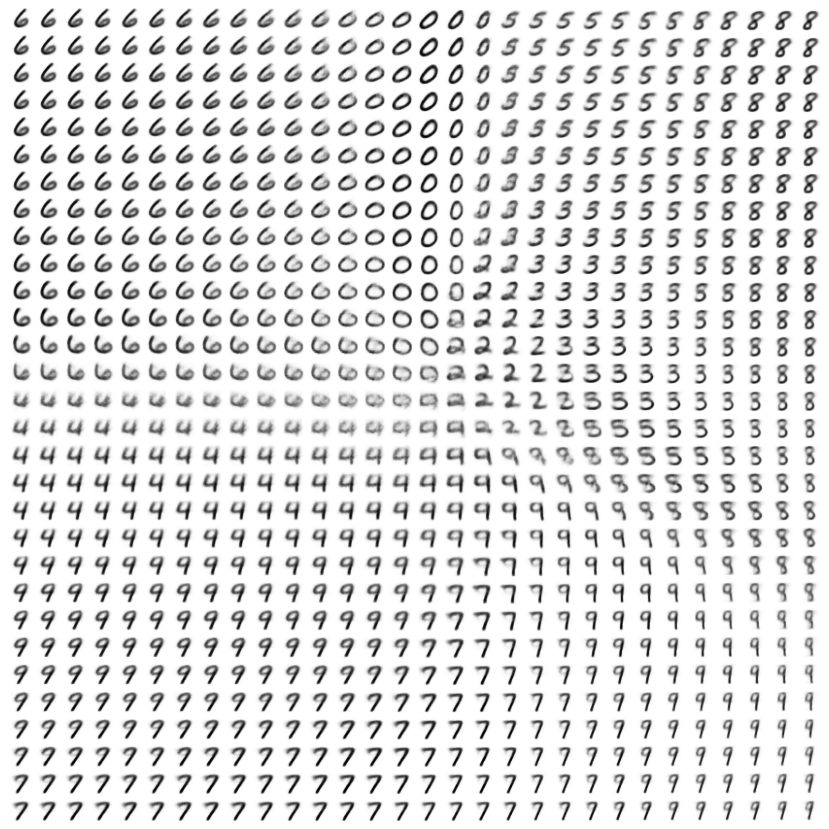

In [10]:
vae=MyVae((28,28,1), 2, 0.7)
vae.compile(optimizer=Adam(), run_eagerly=True) # run_eagerly - для запуска своего пересчета градиента
vae.fit(x_train, epochs=20, batch_size=128)
plot_digits(number_of_digits=30, digit_size=28, decoder=vae.decoder)

# Эксперимент 4
Изменим размерность латентного слоя: было 2, сделаем 10.

Веса loss оставим в равных долях
Визуализировать 10 мерное латентное пространство мы не сможем, но можем посмотреть, как будет себя вести kl_loss

In [12]:
vae=MyVae((28,28,1), 10, 0.5)
vae.compile(optimizer=Adam(), run_eagerly=True) # run_eagerly - для запуска своего пересчета градиента
vae.fit(x_train, epochs=20, batch_size=128)

Epoch 1/20
469/469 [==============================] - 13s 28ms/step - total_loss: 95.9387 - reconstruction_loss: 190.3732 - kl_loss: 1.5041
Epoch 2/20
469/469 [==============================] - 13s 27ms/step - total_loss: 72.1561 - reconstruction_loss: 142.4496 - kl_loss: 1.8627
Epoch 3/20
469/469 [==============================] - 13s 28ms/step - total_loss: 68.4549 - reconstruction_loss: 135.2350 - kl_loss: 1.6749
Epoch 4/20
469/469 [==============================] - 13s 28ms/step - total_loss: 66.7986 - reconstruction_loss: 131.9829 - kl_loss: 1.6143
Epoch 5/20
469/469 [==============================] - 14s 29ms/step - total_loss: 65.7384 - reconstruction_loss: 129.9079 - kl_loss: 1.5690
Epoch 6/20
469/469 [==============================] - 14s 30ms/step - total_loss: 64.9020 - reconstruction_loss: 128.2764 - kl_loss: 1.5277
Epoch 7/20
469/469 [==============================] - 14s 29ms/step - total_loss: 64.3106 - reconstruction_loss: 127.1315 - kl_loss: 1.4895
Epoch 8/20
469/469 [

# Обсуждение эксперимента 4

**kl_loss ожидаемо уменьшился** (почти в 2 раза по сравнению с 2 мерным латентным слоем), и имеет тенденцию к уменьшению с продолжением обучения.